In [2]:
import matplotlib
#from IPython.external import mathjax; mathjax.install_mathjax()
import numpy as np
import math
import sys
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm
#matplotlib.style.use('ggplot')

%matplotlib inline
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Comparing the AME photometry to the dust SED fitting results:

In the 'hp_photometry' notebook, we gathered the AME and IR bands' photometry results for the 98 "AME Regions".
Now that Fred has kindly carried out the SED fitting, based on the AKARI-DIRBE-IRAS-PLANCK IR photometry, we can compare this to the AME.

## Step 1: Load-in the photometry results:

The first thing we do is just re-load our progress so far (the photometry data) into memory.

In [3]:
data_path = "../Data/"

fileout_phot = "../Data/photometry.csv"
fileout_err  = "../Data/errors.csv"
fileout_bg   = "../Data/backgrounds.csv"

healpix_AME = "../Data/raw/COM_CompMap_AME-commander_0256_R2.00.fits" ## Path to AME map
pcxv_AME = "../Data/AME.txt"

fd_all      = np.genfromtxt(fileout_phot,usecols = (0), dtype = 'float', delimiter=',',skip_header=0)
fd_err_all  = np.genfromtxt(fileout_err,usecols = (14), dtype = 'float', delimiter=',',skip_header=1)
fd_bg_all   = np.genfromtxt(fileout_bg,usecols = (0), dtype = 'float', delimiter=',',skip_header=0)

## These lines gets the AME results from Clive's paper, so we can do a comparison:
### Residual (anomalous) 28.4 GHz flux
sres_ame  = np.genfromtxt(pcxv_AME,usecols = (22), dtype = 'float', delimiter=',',skip_header=1)
sres_ame[sres_ame<=0] = np.nan
sres_ame_err = np.genfromtxt(pcxv_AME,usecols = (23), dtype = 'float', delimiter=',',skip_header=1)
sres_ame_err = sres_ame_err**2
sres_ame_err = np.sqrt(sres_ame_err)
### Peak frequency
nu_ame    = np.genfromtxt(pcxv_AME,usecols = (17), dtype = 'float', delimiter=',',skip_header=1)
### Potential fractioanl contribution from an UCHII region...
f_uch     = np.genfromtxt(pcxv_AME,usecols = (19), dtype = 'float', delimiter=',',skip_header=1)
### AME Significance
sig_ame = np.genfromtxt(pcxv_AME,usecols = (16), dtype = 'float', delimiter=',',skip_header=1)
### Dust optical depth
tau_250 = np.genfromtxt(pcxv_AME,usecols = (6), dtype = 'float', delimiter=',',skip_header=1)
## These get the coordinates of the AME regions:
#glat    = np.genfromtxt('inputlist_mep_test.list',usecols = (2), dtype = 'float', delimiter=',')
#glon    = np.genfromtxt('inputlist_mep_test.list',usecols = (1), dtype = 'float', delimiter=',')

### Potential fractioanl contribution from an UCHII region...
f_uch     = np.genfromtxt(pcxv_AME,usecols = (19), dtype = 'float', delimiter=',',skip_header=1)
### AME Significance
sig_ame = np.genfromtxt(pcxv_AME,usecols = (16), dtype = 'float', delimiter=',',skip_header=1)

### Subsets separating "Highly Significant" AME from "Low/Non-significant" AME
subset_hs = (
    
(sig_ame     > 5.000)   & 
(f_uch       <= 0.25)    #& 

)
#print subset_hs

subset_ls = (subset_hs == False)

/home/aaronb/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in greater
/home/aaronb/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in less_equal


## Step 2: Load-in dust SED fitting results:
Now we do the same thing for the SED fitting. Just load the columns from Fred's "results.csv" file into python variables.
(In the future, it may be better to load these as Pandas DataFrames)

In [4]:
##############Model A: Fred's Model############
###############################################
### PAH fraction





qpah    = np.genfromtxt('../Data/fred_results_82616.csv',usecols = (5), dtype = 'float', delimiter=',',skip_header=1)
### Dust mass
dmass   = np.exp(np.genfromtxt('../Data/fred_results_82616.csv',usecols = (1), dtype = 'float', delimiter=',',skip_header=1))
### ISRF (relative to galactic average)
U       = np.exp(np.genfromtxt('../Data/fred_results_82616.csv',usecols = (3), dtype = 'float', delimiter=',',skip_header=1))
### PAH Mass
pahmass = qpah*dmass


import numpy.random as npr
import pylab



### Potential fractioanl contribution from an UCHII region...
#f_uch     = np.genfromtxt(pcxv_AME,usecols = (19), dtype = 'float', delimiter=',',skip_header=1)
### AME Significance
sig_ame = np.genfromtxt(pcxv_AME,usecols = (16), dtype = 'float', delimiter=',',skip_header=1)

### Subsets separating "Highly Significant" AME from "Low/Non-significant" AME
subset_hs = (
    
    (sig_ame     > 5.000)   & 
    (f_uch       <= 0.25)    #& 

    )

subset_ls = (subset_hs == False)

### Subsets for removing points that have a NaN sres_ame value

sres_nonan = np.isnan(sres_ame)==False


/home/aaronb/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in greater
/home/aaronb/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in less_equal


### Load results intp Pandas datafram, instead of individual variables:

In [5]:
#sed_res_path = '/work1/users/aaronb/Databrary/fred_results_82616.csv'



sed_res_path = '../Data/fred_results_83116.csv'

sed_res_data = pd.read_csv(sed_res_path, index_col=False)

print sed_res_data.values[-1,:]
sed_res_data

[-17.44756146   0.24385729  -0.82102316   0.22214018   0.21593254
   0.03360164   1.24956487]


,ln(Md [kg/m2/sr]),sigma(ln(Md)),ln(<U> [Habings]),sigma(ln(<U>)),qPAH,sigma(qPAH),reduced chi-square
0,-18.264398,0.387430,-1.090797,0.389612,0.067420,0.037071,0.179391
1,-17.742847,0.211686,-1.639426,0.193869,0.060807,0.013751,1.075282
2,-15.433045,0.347861,0.483719,0.341430,0.119198,0.024665,0.811917
3,-15.139495,0.197391,0.798847,0.189044,0.084759,0.012609,1.731620
4,-14.865312,0.180398,0.598840,0.167715,0.086649,0.014510,1.491719
5,-15.400239,0.301594,1.674597,0.290501,0.074270,0.024106,2.218849
6,-16.482699,0.502260,1.476809,0.486527,0.092148,0.035852,0.849650
7,-16.934354,0.300428,-2.139893,0.285414,0.117004,0.020630,2.743641
8,-16.366297,0.274812,0.598003,0.273697,0.115292,0.008922,3.120322
9,-14.845270,0.156025,1.187124,0.145781,0.088540,0.011148,1.948685


In [6]:
#Color sorter:

colors = np.empty(np.shape(sig_ame),dtype=str)
print colors

colors[subset_hs==True] = 'r'
colors[subset_ls==True] = 'b'    

print colors

['' '' '' '' '' '' '' '' '\x01' '' '' '' '' '' '' '' '' '' '' '\x01' '' ''
 '' '' '' '' '' '' '' '' '' '' '\x01' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '\x01' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '']
['r' 'r' 'b' 'b' 'b' 'b' 'r' 'r' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
 'r' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'r' 'b'
 'r' 'b' 'b' 'r' 'r' 'b' 'b' 'b' 'r' 'b' 'b' 'r' 'b' 'r' 'r' 'r' 'b' 'b'
 'r' 'b' 'b' 'r' 'r' 'r' 'r' 'b' 'r' 'b' 'r' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
 'b' 'b' 'b' 'r' 'b' 'b' 'b' 'b' 'b' 'r' 'b' 'b' 'b' 'b' 'b' 'r' 'b' 'b'
 'b' 'r' 'b' 'r' 'b' 'r' 'b' 'r']


# Plots of dust vs. AME using Jones+ (2013) model:

0.026 0.006 0.037
0.004 0.002 0.025
0.053 0.01 0.045
0.046 0.038 0.079


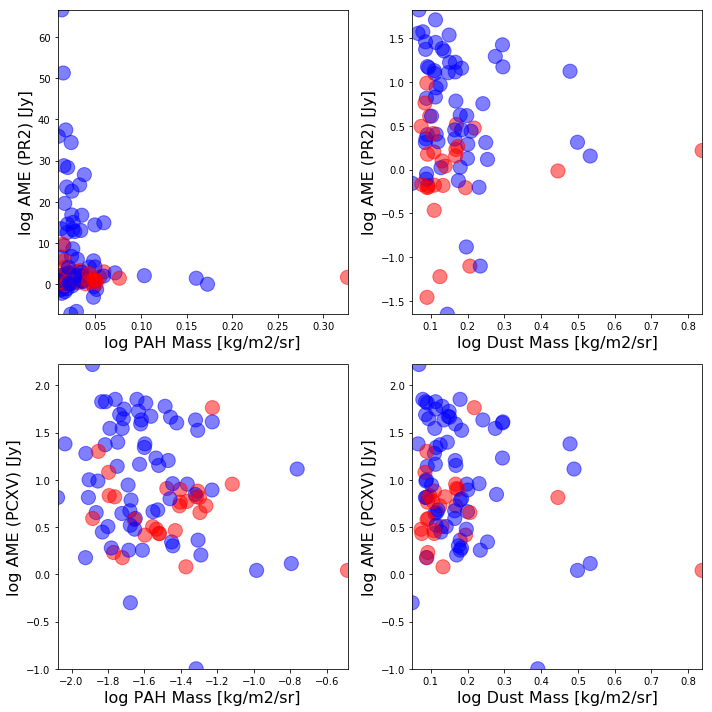

In [8]:
import ameRegs

fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
Y_ = fd_all[:]
X_ = J_qpah*J_dmass

ytitle = "log AME (PR2) [Jy]"
xtitle = "log PAH Mass [kg/m2/sr]"
ameRegs.corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.subplot(2,2,2)
X_ = J_dmass
xtitle = "log Dust Mass [kg/m2/sr]"
ameRegs.corr_plot(X_,Y_, xtitle, ytitle,  logscale=True)

plt.subplot(2,2,3)
Y_ = sres_ame
X_ = J_qpah*J_dmass

ytitle = "log AME (PCXV) [Jy]"
xtitle = "log PAH Mass [kg/m2/sr]"
ameRegs.corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.subplot(2,2,4)
X_ = J_dmass
xtitle = "log Dust Mass [kg/m2/sr]"
ameRegs.corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.tight_layout()
plt.show()
plt.close()

# Plots of dust vs. AME using Galliano+ (2011) model:

0.193 0.042 0.239
0.398 0.093 0.415
0.356 0.13 0.428
0.611 0.243 0.663


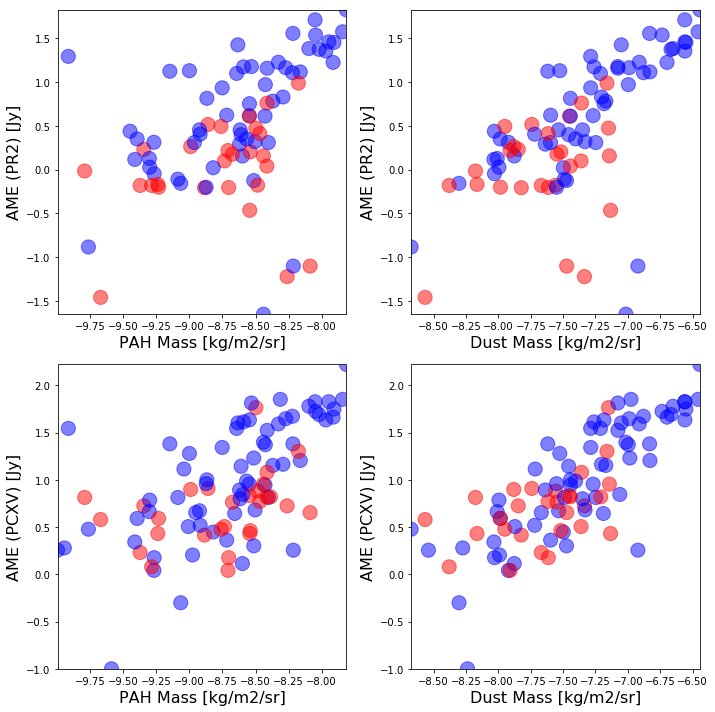

In [7]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
Y_ = fd_all[:]
X_ = qpah*dmass
ytitle = "AME (PR2) [Jy]"
xtitle = "PAH Mass [kg/m2/sr]"


ameRegs.corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.subplot(2,2,2)
X_ = dmass

xtitle = "Dust Mass [kg/m2/sr]"
ameRegs.corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.subplot(2,2,3)
Y_ = sres_ame
X_ = qpah*dmass

ytitle = "AME (PCXV) [Jy]"
xtitle = "PAH Mass [kg/m2/sr]"
ameRegs.corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.subplot(2,2,4)
X_ = dmass
xtitle = "Dust Mass [kg/m2/sr]"
ameRegs.corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.tight_layout()
plt.show()
plt.close()

0.103 0.034 0.087


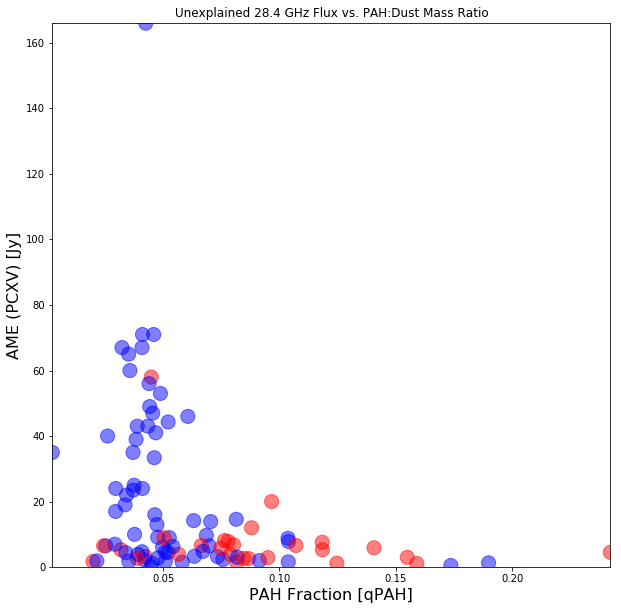

In [8]:
fig = plt.figure(figsize=(10,10))

plt.subplot(1,1,1)
Y_ = sres_ame[:]
X_ = qpah
ytitle = "AME (PCXV) [Jy]"
xtitle = "PAH Fraction [qPAH]"
plt.title("Unexplained 28.4 GHz Flux vs. PAH:Dust Mass Ratio")


ameRegs.corr_plot(X_,Y_, xtitle, ytitle, logscale=False)

## Experimenting with a boostrap test (Per Doi-san's advice')

In [9]:




def bootstrap(data_x, 
              data_y, 
              num_samples, 
              num_subsamples, 
              kind='Spearman'):
    
    from scipy import stats
    
    #"""Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    
    n = len(data_x)
    #print "Data dimen: "+str(np.shape(data))
    
    corr_coeff_array = np.ones(num_samples)
    
    if kind == 'Spearman':
    
        for i in range(0,num_samples):
            idx = npr.randint(0, n, (num_subsamples))
            samples_x = data_x[idx]
            samples_y = data_y[idx]
            stat_r, stat_p = scipy.stats.spearmanr(samples_x,samples_y)
            corr_coeff_array[i] = stat_r
    
    elif kind == 'Pearson':
            
        for i in range(0,num_samples):
            idx = npr.randint(0, n, (num_subsamples))
            samples_x = data_x[idx]
            samples_y = data_y[idx]
            stat_r, stat_p = scipy.stats.pearsonr(samples_x,samples_y)
            corr_coeff_array[i] = stat_r
    
    corr_coeff_array[np.isnan(corr_coeff_array)==False]
    #print stat_r
    
    #print corr_coeff_array
    return corr_coeff_array



def bootstrap_run(X1_data, 
                  X2_data, 
                  Y_data,
                  kind='Pearson', 
                  iterations=10000, 
                  title=None, 
                  X1_label=None, 
                  X2_label=None):
    
    corr_array_X1 = bootstrap(X1_data,Y_data, iterations, len(X1_data),kind=kind )

    corr_array_X2 = bootstrap(X2_data,Y_data, iterations, len(X2_data), kind=kind )
    
    X1 = corr_array_X1
    X2 = corr_array_X2
    
    X1 = X1[~np.isnan(X1)]
    X2 = X2[~np.isnan(X2)]
    
    t, prob = scipy.stats.ttest_ind(X1,X2, axis=0, equal_var=True) #Equal_var=False for Welch's t-test
    # make plots
    
    pylab.figure(figsize=(8,8))

    round_it = 3

    bins = np.linspace(0.1, 1.0, 100)

    pylab.hist(X1, bins, alpha=0.5, color= 'r', label=X1_label +" "+ 
                                           str(round(np.nanmean(X1),round_it)) + " +/- " +  
                                           str(round(np.nanstd(X1),round_it)) )
    pylab.hist(X2, bins, alpha=0.5, color= 'b', label=X2_label+" "+ 
                                           str(round(np.nanmean(X2),round_it)) + " +/- " +  
                                           str(round(np.nanstd(X2),round_it))
                                            + "\n" + "t-stat: "+ 
                                                       str(round(t,round_it))+", p-value: "+   str(round(prob,round_it)))
    
    #if X3_data:
    #    corr_array_lOri_L = bootstrap(X3_data, Y_data, iterations, len(X3_data), kind=kind )
    #    xL = corr_array_lOri_L
        
    #    pylab.hist(xL, bins, alpha=0.5, label=("Dust Luminosity vs. AME \n R = "+ str(round(np.nanmean(xL),round_it))) + " +/- " + str(round(np.nanstd(xL),round_it)))
    
    #corr_array_lOri_L = bootstrap(X3_data, Y_data, iterations, len(X3_data), kind=kind )
    #xL = corr_array_lOri_L
        
    #pylab.hist(xL, bins, alpha=0.5, label=("Dust Luminosity vs. AME \n R = "+ str(round(np.nanmean(xL),round_it))) + " +/- " + str(round(np.nanstd(xL),round_it)))
    
    
    pylab.title('Hist. of Bootstrapped '+kind+' Corr. Results')
    import datetime
    timestamp = datetime.datetime.now().strftime("%I:%M%p%B%d,%Y")

    pylab.savefig('boostrap_'+kind+'_'+timestamp+'.pdf')
    pylab.legend(loc='upper left')
    pylab.show()


    

In [ ]:
dmass[~np.isnan(dmass)]
pahmass[~np.isnan(dmass)]

array([  4.53403412e-10,   4.25349873e-10,   1.21793431e-08,
         1.12953254e-08,   1.43708779e-08,   7.99671631e-09,
         3.18203003e-09,   1.84154946e-09,   5.00367575e-09,
         1.53576996e-08,   6.88390653e-09,   9.54291710e-09,
         5.40282995e-10,   4.70261495e-09,   3.87240935e-09,
         4.26992201e-09,   5.09654689e-09,   4.03802173e-10,
         1.38363628e-09,   3.57023045e-10,   2.39448360e-09,
         2.83787792e-09,   3.87565807e-10,   3.62720238e-09,
         1.19374491e-09,   2.51629102e-09,   5.02153665e-10,
         2.58398222e-10,   4.99011029e-10,   2.45925127e-09,
         1.91508710e-09,   1.11732546e-09,   3.03589846e-10,
         5.42575419e-10,   2.86053698e-09,   1.35705553e-09,
         5.47494971e-09,   1.51508835e-09,   2.20021280e-09,
         3.85965233e-09,   2.13945332e-10,   8.61176609e-10,
         1.13871513e-10,   3.94751353e-09,   1.30146285e-09,
         3.06739684e-09,   2.70717270e-09,   3.27910030e-09,
         9.83210243e-10,

## Calculate bootstrap results using PAH Luminosity ( not PAH Mass)

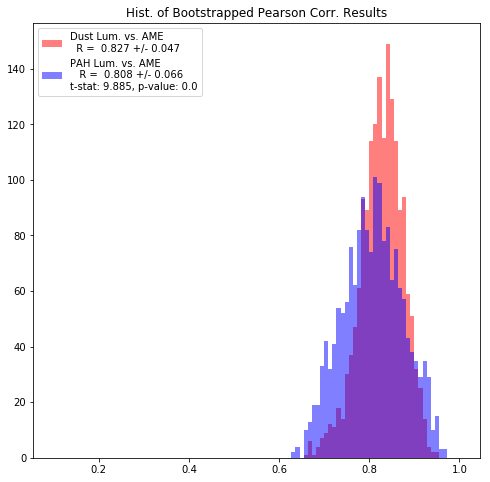

In [ ]:
#Y_data  = fd_all[~np.isnan(fd_all)]
#Y_data = sres_ame[~np.isnan(sres_ame)]
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(<U> [Habings])'].values)*np.exp(sed_res_data['ln(Md [kg/m2/sr])']) 
X2_data = X1_data*sed_res_data['qPAH'].values 
    
X1_label = "Dust Lum. vs. AME \n  R = "
X2_label = "PAH Lum. vs. AME \n   R = "

iterations = 100000

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

#bootstrap_run(X1_data, X2_data, Y_data, X3_data=X3_data, kind=kind, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)
#kind = 'pearson'
#bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)


In [ ]:
Y_data = sres_ame[subset_hs]

X1_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
X2_data = X1_data*sed_res_data['qPAH'].values 
X1_data = X1_data - X2_data
    
X1_label = "Dust Mass. vs. AME \n  R = "
X2_label = "PAH Mass. vs. AME \n   R = "

iterations = 100000

X1_data = X1_data[subset_hs]
X2_data = X2_data[subset_hs]

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
#               X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

#bootstrap_run(X1_data, X2_data, Y_data, X3_data=X3_data, kind=kind, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
              X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)


Y_data = fd_all[subset_hs]

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
#               X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

#bootstrap_run(X1_data, X2_data, Y_data, X3_data=X3_data, kind=kind, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
              X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)
#kind = 'pearson'
#bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)

In [ ]:
Y_data = sres_ame[subset_ls]

X1_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
X2_data = X1_data*sed_res_data['qPAH'].values 
X1_data = X1_data - X2_data
    
X1_label = "Dust Mass. vs. AME \n  R = "
X2_label = "PAH Mass. vs. AME \n   R = "

X1_data=X1_data[subset_ls]
X2_data=X2_data[subset_ls]

iterations = 100000

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
#               X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

#bootstrap_run(X1_data, X2_data, Y_data, X3_data=X3_data, kind=kind, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
              X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)


Y_data = fd_all[subset_ls]

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
#               X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

#bootstrap_run(X1_data, X2_data, Y_data, X3_data=X3_data, kind=kind, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, 
              X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)
#kind = 'pearson'
#bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)

In [ ]:
#Y_data  = fd_all[~np.isnan(fd_all)]
#Y_data = sres_ame[~np.isnan(sres_ame)]
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(<U> [Habings])'].values) 
X2_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
#X3_data = phot_ori['im_lnLdust_tot_best.fits']

iterations = 1000000

X1_label = "U [Habings] vs. AME \n  R = "
X2_label = "Dust Mass  vs. AME \n   R = "

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)
#kind = 'pearson'
#bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)


In [ ]:
#Y_data  = fd_all[~np.isnan(fd_all)]
#Y_data = sres_ame[~np.isnan(sres_ame)]
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(<U> [Habings])'].values)*np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
X2_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
    

iterations = 1000000

X1_label = "Dust Lum. vs. AME \n   R = "
X2_label = "Dust Mass vs. AME \n   R = "

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)


In [ ]:
#Y_data  = fd_all[~np.isnan(fd_all)]
#Y_data = sres_ame[~np.isnan(sres_ame)]
Y_data = sres_ame

X1_data = np.exp(sed_res_data['ln(Md [kg/m2/sr])'].values) 
X2_data = J_dmass


#X3_data = phot_ori['im_lnLdust_tot_best.fits']

iterations = 100000

X1_label = "Dust Mass (Fred) vs. AME \n  R = "
X2_label = "Dust Mass (J13) vs. AME \n   R = "

# kind = 'Pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)

kind = 'Spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, X1_label = X1_label, X2_label = X2_label, iterations=iterations, title=None)


In [ ]:
Y_data  = fd_all[~np.isnan(fd_all)]
X1_data = dmass #[~np.isnan(dmass)]
X2_data = pahmass #[~np.isnan(pahmass)]
#X3_data = phot_ori['im_lnLdust_tot_best.fits']

iterations = 10000

#kind = 'pearson'

#bootstrap_run(X1_data, X2_data, Y_data, X3_data=X3_data, kind=kind, iterations=iterations, title=None)

kind = 'spearman'
bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)
# kind = 'pearson'
# bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)


In [ ]:
kind = 'spearman'
iterations = 10000000


Y_data  = fd_all[subset_hs]
X1_data = dmass[subset_hs] #[~np.isnan(dmass)]
X2_data = pahmass[subset_hs] #[~np.isnan(pahmass)]

bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)





In [ ]:
iterations = 1000000


Y_data  = fd_all[subset_ls]
X1_data = dmass[subset_ls] #[~np.isnan(dmass)]
X2_data = pahmass[subset_ls] #[~np.isnan(pahmass)]

bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)


In [ ]:
iterations = 1000000

Y_data  = sres_ame[subset_hs]
X1_data = dmass[subset_hs] #[~np.isnan(dmass)]
X2_data = pahmass[subset_hs] #[~np.isnan(pahmass)]

bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)

Y_data  = sres_ame[subset_ls]
X1_data = dmass[subset_ls] #[~np.isnan(dmass)]
X2_data = pahmass[subset_ls] #[~np.isnan(pahmass)]

bootstrap_run(X1_data, X2_data, Y_data, kind=kind, iterations=iterations, title=None)

In [ ]:
print len(sres_ame)
print len(fd_all)
print fd_all[np.isnan(fd_all)==False]
print fd_all[np.isnan(fd_all)==True]
print sres_ame[np.isnan(sres_ame)==False]
print sres_ame[np.isnan(sres_ame)==True]
print corr_array_hs[np.isnan(corr_array_hs)==False]

# AME to Dust comparisons, without background subtraction of the AME:

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
Y_ = fd_all[:]+fd_bg_all[:]
X_ = qpah*dmass
ytitle = "AME (PR2) [Jy]"
xtitle = "PAH Mass [kg/m2/sr]"
corr_plot(X_,Y_, title, xtitle, ytitle)

plt.subplot(2,2,2)
X_ = dmass
xtitle = "Dust Mass [kg/m2/sr]"
corr_plot(X_,Y_, title, xtitle, ytitle)

plt.subplot(2,2,3)
Y_ = sres_ame
X_ = qpah*dmass
ytitle = "AME (PCXV) Photometry [ Jy ]"
xtitle = "PAH Mass [kg/m2/sr]"
corr_plot(X_,Y_, title, xtitle, ytitle)

plt.subplot(2,2,4)
X_ = dmass
xtitle = "Dust Mass [kg/m2/sr]"
corr_plot(X_,Y_, title, xtitle, ytitle)

plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
Y_ = J_qpah
X_ = J_dmass
ytitle = "Dust Mass [kg/m2/sr]"
xtitle = "q_PAH"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.show()
plt.close()

### Dust Mass (THEMIS) vs. AME

In [ ]:

fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
Y_ = fd_all[:]+fd_bg_all[:]
X_ = J_qpah*J_dmass
ytitle = "AME (PR2) [Jy]"
xtitle = "PAH Mass [kg/m2/sr]"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.subplot(2,2,2)
X_ = J_dmass
xtitle = "Dust Mass [kg/m2/sr]"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.show()
plt.close()

# Comparison of AME Photometry with $\tau_{250}$

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
# "Dust vs. High Sig. AME"
Y_ = fd_all[:]
X_ = tau_250[:]
ytitle = "AME (PR2) [Jy]"
xtitle = "$\\tau_{250}$ (PCXV)"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)

plt.subplot(2,2,2)
Y_ = sres_ame[:]
X_ = tau_250[:]
#"Clive's Optical Depth vs. AME"
ytitle = "AME (PCXV) [Jy]"
xtitle = "$\\tau_{250}$ (PCXV)"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)


plt.tight_layout()
plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(16,16))
###############################################################
### First, plot the regions /with/ background subtraction######
###############################################################
Y_ = fd_all
X_ = sres_ame

plt.subplot(2,2,1,adjustable='box')
#plt.title("With background subtraction")
ytitle="AME (PR2) [Jy]"
xtitle="AME (PCXV) [Jy]"
corr_plot(X_,Y_, xtitle, ytitle, logscale=True)


from sklearn import svm, datasets

C = 1.0
svc = svm.SVC(kernel='linear', C=C).fit([X_[50:60], Y_[50:60]],2)


###############################################################
### Now, plot them  /without/ background subtraction###########
################################################################
#Y_ = fd_all+fd_bg_all##########################################
###############################################################
#X_ = sres_ame
#plt.subplot(2,2,2,adjustable='box')
#plt.title("Without background subtraction")
#ytitle="AME (PR2) [Jy]"
#xtitle="AME (PCXV) [Jy]"

#corr_plot(X_,Y_,  xtitle, ytitle, logscale=True)


In [ ]:
filters = pd.DataFrame.from_csv("/work1/users/aaronb/Codebrary/Python/filters_PAH.dat", header=0)

In [ ]:
print filters['IRAS12/PAH1']

In [ ]:
filters.columns

In [ ]:
plt.figure(); filters[['IRAS12/PAH0','IRC09/PAH0','IRAS12/PAH1','IRC09/PAH1']].plot(logx=True)

In [ ]:
filters[['IRC09/PAH0','IRC09/PAH1','IRAS12/PAH0','IRAS12/PAH1','WISE12/PAH0','WISE12/PAH1']].ix[5].plot(kind='bar',stacked=True); plt.axhline(0, color='k')

In [ ]:
filters[['IRAS12/PAH0','IRC09/PAH0','IRAS12/PAH1','IRC09/PAH1']].plot.bar(); plt.axhline(0, color='k')

In [ ]:
plt.figure(); filters[['IRAS12/PAH0', 'IRAS12/PAH1', 'IRAS12/SAmC', 'IRAS12/LAmC',
       'IRAS12/ASIL', 'IRAS12/TOTAL', 'IRAS25/PAH0', 'IRAS25/PAH1',
       'IRAS25/SAmC', 'IRAS25/LAmC', 'IRAS25/ASIL', 'IRAS25/TOTAL',
       'WISE12/PAH0', 'WISE12/PAH1', 'WISE12/SAmC', 'WISE12/LAmC',
       'WISE12/ASIL', 'WISE12/TOTAL', 'WISE22/PAH0', 'WISE22/PAH1',
       'WISE22/SAmC', 'WISE22/LAmC', 'WISE22/ASIL', 'WISE22/TOTAL',
       'IRC09/PAH0', 'IRC09/PAH1', 'IRC09/SAmC', 'IRC09/LAmC',
       'IRC09/ASIL', 'IRC09/TOTAL', 'IRC18/PAH0', 'IRC18/PAH1',
       'IRC18/SAmC', 'IRC18/LAmC', 'IRC18/ASIL', 'IRC18/TOTAL']].plot(logx=True)

In [ ]:
plt.figure(figsize=(40,40)); filters[['IRAS12/PAH0', 'IRAS12/PAH1', 
                        'WISE12/PAH0', 'WISE12/PAH1',
                       'IRC09/PAH0', 'IRC09/PAH1', ]].plot(logx=True)

In [ ]:
plt.figure(figsize=(20,20)); filters[['IRAS12/TOTAL',  
                        'WISE12/TOTAL', 
                       'IRC09/TOTAL']].plot(logx=True)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
filters_dir = "/work1/users/aaronb/Databrary/Filters/"
iras12 = pd.read_csv(filters_dir+"filter_iras12", names= ['Wavelength','IRAS12'], header=0)
wise12 = pd.read_csv(filters_dir+"filter_wise12", names= ['Wavelength','WISE12'], header=0)
akari9 = pd.read_csv(filters_dir+"filter_akari9", names= ['Wavelength','AKARI9'], header=0)
akari18 = pd.read_csv(filters_dir+"filter_akari18", names= ['Wavelength','AKARI18'], header=0)
iras25 = pd.read_csv(filters_dir+"filter_iras25", names= ['Wavelength','IRAS25'], header=0)
#rsr = wise12.merge(akari9, how = 'outer', on='Wavelength')
#rsr = rsr.merge(iras12)
#rsr.sort_values(by='Wavelength', inplace=True)
fig = plt.figure()
ax1 = fig.add_subplot(111)

#wise12_norm['WISE12'] = (wise12['WISE12'] - wise12['WISE12'].mean()) / (wise12['WISE12'].max() - wise12['WISE12'].min())
wise12_norm = wise12
wise12_norm['WISE12'] = (wise12['WISE12']  / wise12['WISE12'].max())

wise12_norm.plot(x='Wavelength',logx=False, xlim=(5,35), ax=ax1)
akari9.plot(x='Wavelength',logx=False, xlim=(5,35), ax=ax1)
iras12.plot(x='Wavelength',logx=False, xlim=(5,35), ax=ax1)
akari18.plot(x='Wavelength',logx=False, xlim=(5,35), ax=ax1)
iras25.plot(x='Wavelength',logx=False, xlim=(5,35), ylim = (0.1,1), ax=ax1)

In [ ]:
wise12_norm.max()

In [ ]:
rsr

In [ ]:
fd_all[1]

In [ ]:
plt.scatter(nu_ame,sres_ame)
plt.scatter(nu_ame,sres_ame/fd_all[0])
plt.scatter(nu_ame,sres_ame/fd_all[1])
plt.ylim(0,50)
plt.xlim(20,50)

In [ ]:
#plt.hist(nu_ame,bins=100)
np.nanmedian(nu_ame)
np.nanmean(nu_ame)

